# Разреженные признаки и Vowpal Wabbit

### 21.03.2017

#### Мельник Богдан

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

In [90]:
import pandas as pd
import scipy.sparse

from IPython.display import Image, display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

## Примеры источников разреженных признаков

* Результат one-hot-encoding для большого количества категориальных признаков
* Тексты и любые последовательности, которые можно интерпретировать как "bag of words"

## Разреженные матрицы

Существует много типов разреженных матриц, каждый из которых предоставляет разные гарантии на операции.

* ```scipy.sparse.bsr_matrix```
* ```scipy.sparse.coo_matrix```
* ```scipy.sparse.csc_matrix```
* ```scipy.sparse.csr_matrix```
* ```scipy.sparse.dia_matrix```
* ```scipy.sparse.dok_matrix```
* ```scipy.sparse.lil_matrix```

Подробнее про [устройство разреженых матрицы](http://www.netlib.org/utk/people/JackDongarra/etemplates/node372.html)

## scipy.sparse.coo_matrix

* Используется как хранилище данных
* Поддерживает быструю конвертацию в любой формат
* Не поддерживает индексацию
* Поддерживает ограниченый набор арифметических операций

In [124]:
coo = scipy.sparse.random(10000, 10000, format='coo')

In [125]:
print(coo[0])

TypeError: 'coo_matrix' object does not support indexing

## scipy.sparse.csr_matrix

* Хранит данные построчно
* Быстрое получение значений отдельных строк

## scipy.sparse.csc_matrix

* Хранит данные поколоночно
* Быстрое получение значений отдельных колонок

In [137]:
%%timeit

m = scipy.sparse.csr_matrix((10000, 10000))
for _ in range(10000):
    m[np.random.randint(0, 10000), np.random.randint(0, 10000)] = 1

1 loop, best of 3: 4.44 s per loop


## scipy.sparse.lil_matrix

* Отлично подходит для создания разреженных матриц поэлементно
* Для последующих матричных операций лучше сконвертировать в ```csr_matrix``` или ```csc_matrix```

In [138]:
%%timeit

m = scipy.sparse.lil_matrix((10000, 10000))
for _ in range(10000):
    m[np.random.randint(0, 10000), np.random.randint(0, 10000)] = 1

10 loops, best of 3: 100 ms per loop


## Работа с разреженными данными

Библиотека ```scipy.sparse``` содержит методы, позволяющие работать с разреженными матрицами.

Например, специальные ```hstack``` и ```vstack``` для конкатенации.

Подробнее про операции с разрежеными матрицами на сайте [scipy](https://docs.scipy.org/doc/scipy/reference/sparse.html).

### Что можно использовать?

Подходят почти все модели
* LogisticRegression
* LinearSVC
* MultinomialNB
* RandomForestClassifier
* KNeighborsClassifier

Не подходят
* GradientBoostingClassifier

## Пример с текстами

* Датасет StackOverflow
    * Случайная выборка из 10 тысяч вопросов
    * Только 20 популярных тегов
* По тексту нужно определить все теги для каждого вопроса

In [7]:
texts = pd.read_csv('multi_tag.10k.tsv', header=None, sep='\t')
texts.columns = ['text', 'tags']
print(texts.shape)
texts.head(4)

(10000, 2)


,text,tags
0,i want to use a track bar to change a form s ...,c# winforms type-conversion decimal opacity
1,i have an absolutely positioned div containin...,html css css3 internet-explorer-7
2,given a datetime representing a person s birt...,c# .net datetime
3,given a specific datetime value how do i disp...,c# datetime datediff relative-time-span


## Оценка качества

* Будем использовать обобщение $F1$-меры на несколько классов


$$
F1 = 2\frac{p * r}{p + r},\ \ \mathrm{где}\ \ p = \frac{tp}{tp+fp},\ \  r = \frac{tp}{tp+fn}
$$


$tp$, $fp$ и $fp$ считаются по всем тегам одного объекта

In [8]:
y, y_hat = np.array([[1, 1, 0, 0]]), np.array([[1, 0, 1, 0]])
tp, fp, fn = 1., 1., 1.
p, r = tp / (tp + fp), tp / (tp + fn)
f1 = 2 * p * r / (p + r)

print(f1)
print(f1_score(y, y_hat, average='samples'))

0.5
0.5


## Bag of words

Построим модель BOW с помощью ```CountVectorizer```
* Для каждого отдельного слова будет создана колонка
* В пересечении строки и колонки будет стоять 1, если это слово присутствует в документе
* ```CountVectorizer``` возвращает ```scipy.sparse.csr.csr_matrix```
* Если рассматривать вхождение каждого отдельного слова как признак, то мы получим $35247$ признаков

In [80]:
vectorizer = CountVectorizer(binary=True)
bow = vectorizer.fit_transform(texts.text)
print(bow.shape)
print(type(bow))

(10000, 35247)
<class 'scipy.sparse.csr.csr_matrix'>


## Отбор тегов

* Оставим только самые популярные 20 тегов для предсказания
* Если у вопроса после такой фильтрации не осталось тегов, то присвоим ему отдельный тег __other__

In [13]:
tags = texts.tags.apply(lambda x: x.split())
all_tags = reduce(lambda s, x: s + x, tags, [])
values, count = np.unique(all_tags, return_counts=True)

top_tags = sorted(zip(count, values), reverse=True)[:20]
top_tags[:10]

[(1198, 'c#'),
 (1090, '.net'),
 (696, 'java'),
 (610, 'asp.net'),
 (472, 'sql-server'),
 (462, 'c++'),
 (434, 'javascript'),
 (372, 'sql'),
 (363, 'php'),
 (349, 'windows')]

In [14]:
def filter_tags(tags):
    intersection = list(good_tags.intersection(tags))
    if intersection:
        return intersection
    return ['other']

good_tags = set(map(lambda x: x[1], top_tags))

Преобразуем списки тегов в матрицу, которая будет содержать индикаторы наличия тега у вопроса.

Для одного вопроса может быть несколько единиц.

In [19]:
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(texts.tags.apply(lambda x: filter_tags(x.split())))
print(y.shape)
print(y[:5, :])

(10000, 21)
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


## Выбор модели и оценка

* Будет использовать ```LogisticRegression``` вместе с ```OneVsRestClassifier``` для получения предсказаний

In [204]:
params = {'estimator__C': np.logspace(-5, 5, 11)}

clf = OneVsRestClassifier(LogisticRegression())
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score, average='samples'), cv=5)
cv.fit(bow, y);

## Выбор модели и оценка

* $F1 = 0.4047323$
* Как можно улучшить качество модели?

In [205]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
10,0.404732,{u'estimator__C': 100000.0}
9,0.404212,{u'estimator__C': 10000.0}
8,0.404140,{u'estimator__C': 1000.0}
7,0.403066,{u'estimator__C': 100.0}
6,0.402630,{u'estimator__C': 10.0}
5,0.390346,{u'estimator__C': 1.0}
4,0.319707,{u'estimator__C': 0.1}
3,0.092920,{u'estimator__C': 0.01}
2,0.000300,{u'estimator__C': 0.001}
0,0.000000,{u'estimator__C': 1e-05}


## Tf-Idf

* Вместо бинарного значения, для каждого слова считать его вес в документе.
* Обычно работает лучше, чем ```CountVectorizer```
* Реализовано в ```TfidfVectorizer```

Значение Tf-Idf для каждого пары документ-слово состоит из двух компонент:
* Term frequency — логарифм встречаемости слова в документе
$$tf(t, d) = \log n_{t,d}$$

* Inverse Document frequency — логарифм обратной доли документов в которых встретилось данное слово
$$idf(t, D) = \log \frac{ \mid D \mid}{\mid \{ d_i \in D \mid t \in d_i \} \mid}$$

* Tf-Idf — кобминация tf и idf
$$ TfIdf(t, d, D) = tf(t, d) * idf(t, D)$$

In [81]:
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(texts.text)
print(tf_idf.shape)
print(type(tf_idf))

(10000, 35247)
<class 'scipy.sparse.csr.csr_matrix'>


## Выбор модели и оценка

Ищем лучшие параметры

In [254]:
params = {'estimator__C': np.logspace(-5, 5, 11)}

clf = OneVsRestClassifier(LogisticRegression())
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score, average='samples'), cv=5)
cv.fit(tf_idf, y);

## Выбор модели и оценка

* $F1=0.382173$
* Получилось хуже, чем BOW.
* Но почему?

In [255]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
10,0.382173,{u'estimator__C': 100000.0}
9,0.380033,{u'estimator__C': 10000.0}
8,0.376427,{u'estimator__C': 1000.0}
7,0.364680,{u'estimator__C': 100.0}
6,0.334247,{u'estimator__C': 10.0}
5,0.182323,{u'estimator__C': 1.0}
4,0.000700,{u'estimator__C': 0.1}
0,0.000000,{u'estimator__C': 1e-05}
1,0.000000,{u'estimator__C': 0.0001}
2,0.000000,{u'estimator__C': 0.001}


## Выбор порога

* При вызове ```predict``` возвращается 1, если вероятность принадлежности к классу больше $0.5$
* Можно выбирать порог самому через кросс-валидацию

In [82]:
clf = OneVsRestClassifier(LogisticRegression(C=100000))
%time y_hat_bow = cross_val_predict(clf, bow, y, method='predict_proba')
%time y_hat_tf_idf = cross_val_predict(clf, tf_idf, y, method='predict_proba')

CPU times: user 15.4 s, sys: 109 ms, total: 15.5 s
Wall time: 15.6 s
CPU times: user 10.9 s, sys: 55.4 ms, total: 11 s
Wall time: 11 s


Функция, которая в зависимости от порога ставит тег

In [44]:
def get_score(alpha, y, y_hat):
    return f1_score(y, (y_hat > alpha).astype('int'), average='samples')

## Выбор порога для BOW

* Качество с порогом по умолчанию — $F1=0.404732$
* Качество с подобранным порогом — $F1=0.454356$

0.454356904762
0.00535353535354


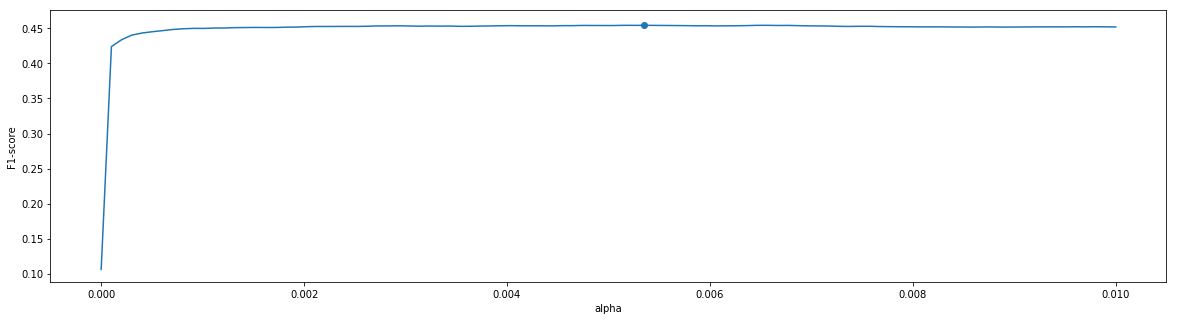

In [88]:
alphas = np.linspace(0.0, 0.01, 100)
scores = [get_score(alpha, y, y_hat_bow) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
ylabel('F1-score')
xlabel('alpha')


print(np.max(scores))
print(alphas[np.argmax(scores)])

## Выбор порога для Tf-Idf

* Качество с порогом по умолчанию — $F1=0.382173$
* Качество с подобранным порогом — $F1=0.493972$

0.493972857143
0.00191919191919


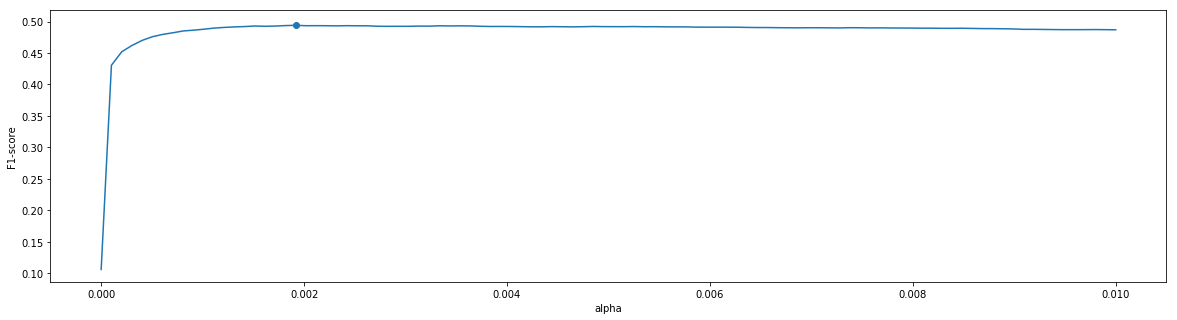

In [58]:
alphas = np.linspace(0.0, 0.01, 100)
scores = [get_score(alpha, y, y_hat_tf_idf) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
ylabel('F1-score')
xlabel('alpha')

print(np.max(scores))
print(alphas[np.argmax(scores)])

## BM25

Метод вычисления весов ```Okapi BM25``` развивает идею Tf-Idf, учитывая длину документов в $tf(t, d)$.

$$tf(t, d) = \frac{(K_1 + 1) * n_{t,d}}{k_1 * (1 - b + b * \frac{L_d}{L_{ave}}) + n_{t,d}}$$

где
* $L_{ave}$ — средняя длина документа
* $1.2 \leqslant k \leqslant 2$
* $b = 0.75$

## N-граммы

* При увеличении N количество признаков стремительно растёт
* Даже для 10 тысяч объектов валидация и подбор гиперпараметров существенно замедляются

In [66]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
bow = vectorizer.fit_transform(texts.text)
print(bow.shape)

(10000, 1132373)


Чем больше признаков, тем больше мы будем тратить времени на оценку и подбор гиперпараметров.

In [68]:
%time y_hat_bow = cross_val_predict(clf, bow, y, method='predict_proba')

CPU times: user 1min 58s, sys: 4.28 s, total: 2min 3s
Wall time: 2min 4s


## Оценка N-грамм

* С $N \in \{1, \dots, 3\}$ и $1132373$ признаков получилось $F1 = 0.5275$
* ```cross_val_predict``` занял ```2min 4s```

0.527566904762
0.00131313131313


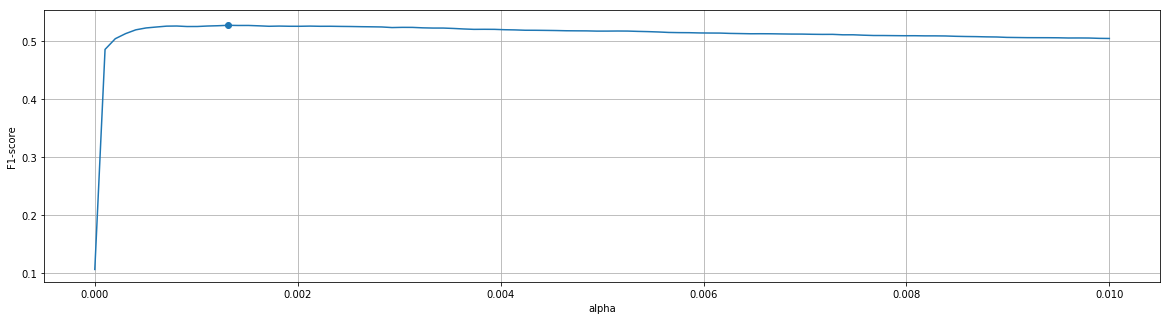

In [70]:
alphas = np.linspace(0.0, 0.01, 100)
scores = [get_score(alpha, y, y_hat_bow) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
grid()
ylabel('F1-score')
xlabel('alpha')

print(np.max(scores))
print(alphas[np.argmax(scores)])

## Hashing Trick

Вместо того, чтобы хранить каждый вариант N-граммы отдельно, мы будем получать индекс столбца с признаком, хешируя содержимое.

Позволяет задавать произвольное количество столбцов и контролировать максимальное количество признаков соответственно.

In [73]:
vectorizer = HashingVectorizer(binary=True, ngram_range=(1, 3), n_features=100000)
bow = vectorizer.fit_transform(texts.text)
print(bow.shape)
print(type(bow))

(10000, 100000)
<class 'scipy.sparse.csr.csr_matrix'>


In [280]:
params = {'estimator__C': np.logspace(-5, 5, 11)}

clf = OneVsRestClassifier(LogisticRegression())
cv = GridSearchCV(clf, params, n_jobs=-1, scoring=make_scorer(f1_score, average='samples'), cv=5)
cv.fit(bow, y);

In [281]:
pd.DataFrame(cv.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
10,0.280800,{u'estimator__C': 100000.0}
9,0.275890,{u'estimator__C': 10000.0}
8,0.265307,{u'estimator__C': 1000.0}
7,0.247607,{u'estimator__C': 100.0}
6,0.200850,{u'estimator__C': 10.0}
5,0.055257,{u'estimator__C': 1.0}
0,0.000000,{u'estimator__C': 1e-05}
1,0.000000,{u'estimator__C': 0.0001}
2,0.000000,{u'estimator__C': 0.001}
3,0.000000,{u'estimator__C': 0.01}


In [74]:
%time y_hat_bow = cross_val_predict(clf, bow, y, method='predict_proba')

CPU times: user 48.1 s, sys: 508 ms, total: 48.6 s
Wall time: 48.8 s


## Выбор порога для HashingTrick

* Сократив количество признаков до $100000$ мы получили $F1=0.525578$
* Качество уменьшилось не сильно, но при этом время затраченное на ```cross_val_predict``` сократилось более чем в 2 раза до ```48.8 s```

0.525578571429
0.00222222222222


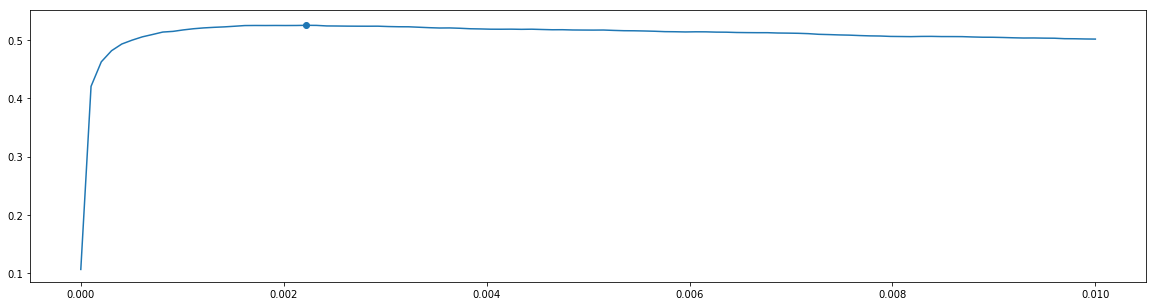

In [75]:
alphas = np.linspace(0.0, 0.01, 100)
scores = [get_score(alpha, y, y_hat_bow) for alpha in alphas]

plot(alphas, scores);
scatter(alphas[np.argmax(scores)], np.max(scores));
print(np.max(scores))
print(alphas[np.argmax(scores)])

## VW

* Разработка Yahoo и потом Microsoft
* Библиотека и __CLI__ программа, позволяющая строить линейные модели
* Способна обрабатывать миллиарды объектов с сотнями тысяч признаков

## Установка VW

* Ubuntu — ```apt-get instal vowpal-wabbit```
* Mac OS — ```port install vowpal_wabbit```
* Windows — скачать установочник [тут](https://github.com/eisber/vowpal_wabbit/releases)

[Варианты](https://github.com/JohnLangford/vowpal_wabbit/wiki/Download) установки из официальной wiki

## Проверяем VW

In [21]:
!vw -h | head -n10

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 


## Формат ввода

* Использует специальный формат входных данных
* ```Label [weight] |Namespace Feature ... |Namespace ...```
    * ```Label``` — метка класса для задачи классификации или действительное число для задачи регрессии
    * ```weight``` — вес объекта, по умолчанию у всех 1
    * ```Namespace``` — все признаки разбиты на области видимости, может использоваться для раздельного использования или создания квадратичных признаков между областями
    * ```Feature``` — ```string[:value]``` или ```int[:value]``` строки будут хешированы, числа будут использоваться как индекс в векторе признаков. ```value``` по умолчанию равно $1$

## Hashing trick

Вводится функция $h$, с помощью которой получается индекс для записи значения в вектор признаков объекта.

$$h : F \rightarrow \{0, \dots, 2^b - 1\}$$

С помощью ```--b``` можно задавать размер области значений хеш-функции. Чем больше значение ```b```, тем меньше вероятность получить коллизии при хешировании признаков.

## Optimization

Может использовать ```SGD``` или ```L-BFGS``` (квази-ньютоновский метод второго порядка, подробнее про работу [оптимизации](http://aria42.com/blog/2014/12/understanding-lbfgs))

* ```SGD``` по умолчанию. Почти всегда необходимо несколько проходов по данным.
* ```L-BFGS``` включается с помощью ```--bfgs```, работает гораздо медленнее и только для выборок небольшого размера
* Количество проходов для ```SGD``` задаётся с помощью параметра ```--passes```



## Параметры оптимизации

Проходим по всем элементам обучающей выборки много раз, на каждом объекте обновляем веса:
<br/>


$$w_{t+1} = w_{t} + \eta_t \nabla_{w}\ell(w_{t}, x_{t})$$
$$\eta_t = \lambda d^k \left( \frac{t_0}{t_0 + t} \right)^p$$

Здесь $t$ — номер объекта при обучении, $k$ — номер эпохи.

* $\lambda$: ```-l```
* $d$: ```--decay_learning_rate```
* $t_0$: ```--initial_t```
* $p$: ```--power_t```

## Оценка качества

Перед учётом очередного элемента в обучении на нём считается ошибка $e_i$. Далее эта ошибка усредняется со всеми предыдущими, получая текущую оценку качества.

$$\text{progressive error} = \frac{e_1 + e_2 + ... + e_s}{s}$$

$e_i$ — loss на объекте $x_i$ при обучении на объектах $\{x_1 ... x_{i-1}\}$


Подробнее про использование [progressive validation](http://hunch.net/~jl/projects/prediction_bounds/progressive_validation/coltfinal.pdf)










## Функции потерь

Задаются через опцию ```--loss_function```

<img src="files/images/loss.png" width="800">

## Регуляризация 

Задаётся через два флага
* ```--l1```
* ```--l2```

## Квадратичные признаки

* ```-q ab``` — создаёт квадратичные признаки, перемножая все признаки из областей видимости, названия которых начинаются на букву __a__ и на букву __b__
* ```--ignore a``` — игнорирует все признаки из области видимости, название которой начинается на букву __a__



## Режим демона

* ```--daemon``` — запускает __vw__ в режиме сервиса на порту, который можно задать с помощью ```--port```
* Позволяет обучать модель и/или применять модель по сети

## Примеры для бинарной классификации

* Два класса с признаками A и B

<pre>
-1 | A:1 B:10
 1 | A:-1 B:12
</pre>

* Можно использовать текст без обработки

<pre>
-1 | so i find myself porting a game that was originally written
 1 | i ve been using tortoisesvn in a windows environment for quite some time
</pre>

## ```windows vs linux```

Оставим только вопросы, в которых есть тег __windows__ или __linux__ и сконвертируем данные в формат подходящий для ```vw```.

In [22]:
texts = pd.read_csv('windows_vs_linux.10k.tsv', sep='\t', header=None)
texts[1].replace({0: '-1 ', 1: '1 '}, inplace=True)

train_texts, test_texts = train_test_split(texts)


train_texts[[1, 0]].to_csv('win_vs_lin.train.vw', sep='|', header=None, index=False)
test_texts[[1, 0]].to_csv('win_vs_lin.test.vw', sep='|', header=None, index=False)

!head -n 5 win_vs_lin.train.vw | cut -c 1-50

-1 | as the title says does any unix like system a
-1 | i want to link ln s all files that are in mnt
1 | in windows xp 2003 there is one entry in the r
-1 | how could i forward the x window output from 
-1 | as the title says what s your ide of choice t


## Обучение

In [184]:
!vw -d win_vs_lin.train.vw -f model.vw --loss_function logistic  --passes 100 -c -k 2> train.log

* ```-d``` — откуда брать данны для обучения
* ```-f``` — куда сохранять модель
* ```--passes``` — максимальное количество проходов по выборке
* ```-c``` — создавать файл с кешем, необходимо указывать, если используется ```--passes```
* ```-k``` — перед запуском очищать кеш

## Лог обучения

In [186]:
!head -n20 train.log

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = win_vs_lin.train.vw.cache
Reading datafile = win_vs_lin.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000      101
0.632252 0.571357            2            2.0  -1.0000  -0.2605       28
0.652016 0.671781            4            4.0  -1.0000  -1.6879      135
0.882366 1.112717            8            8.0   1.0000   0.0338       19
0.848898 0.815429           16           16.0  -1.0000  -0.5651       69
0.886803 0.924707           32           32.0   1.0000  -0.3310      161
0.793671 0.700539           64           64.0   1.0000   1.3198      197
0.721078 0.648484          128          128.0   1.0000  -0.5368       16
0.634201 0.547324          256          256.0  

## Применение

In [187]:
!vw -d win_vs_lin.test.vw -i model.vw -t -p output.csv --quiet
!head -n3 output.csv

0.072026
2.981259
2.415733


* ```-i``` — путь до готовой модели
* ```-t``` — не обучаться, только вернуть предсказания
* ```-p``` — путь до файла для записи предсказаний
* ```--quite``` — не выводить никакую информацию в консоль

## Результат

Загрузим ответы и померяем $AUC$

In [188]:
y_hat = pd.read_csv('output.csv', header=None)
roc_auc_score(test_texts[1].replace({'-1 ': 0, '1 ': 1}), y_hat[0])

0.96704167103343197

## Многоклассовая классификация

Включается с помощью флага ```--oaa n```, где $n$ число классов.

Формат для меток — ```label[:weight],label[:weight],...```

In [172]:
texts = pd.read_csv('multi_tag.10k.tsv', header=None, sep='\t')
texts.columns = ['text', 'tags']
classes = np.arange(21)
texts['tags'] = map(lambda row: ','.join(map(str, 1 + classes[row.astype('bool')])) + ' ', y)
texts[['tags', 'text']].to_csv('multi_tag.vw' , sep='|', header=None, index=False)

!head -n 5 multi_tag.vw | cut -c 1-50

4 | i want to use a track bar to change a form s o
7 | i have an absolutely positioned div containing
1,4 | given a datetime representing a person s bir
4 | given a specific datetime value how do i displ
7,9 | is there any standard way for a web server t


## Обучение

In [173]:
!vw -d multi_tag.vw  -f model.vw --loss_function logistic --oaa 21 --quiet --passes 100 -c -k

## Предсказание

Для простоты получим ответы на ```train```

In [177]:
!vw -d multi_tag.vw -i model.vw -r output.csv --loss_function logistic --quiet 
!head -n3 output.csv

1:-2.48879 2:-2.2027 3:-3.81814 4:1.25513 5:-3.72094 6:-6.52962 7:-5.75792 8:-4.49483 9:-3.05773 10:-6.86743 11:-6.08145 12:-1.01415 13:-6.79665 14:-4.62895 15:-4.18816 16:-3.87795 17:-5.31658 18:-4.34753 19:-2.65281 20:-6.11897 21:-4.71674
1:-5.77629 2:-4.70643 3:-8.05376 4:-2.97062 5:-8.84354 6:-10.7255 7:2.6422 8:-5.72566 9:-3.39589 10:-8.78461 11:-7.98634 12:-3.78309 13:-6.47153 14:-9.07742 15:-10.1064 16:-9.9607 17:-10.6715 18:-11.5456 19:-9.8694 20:-8.54887 21:-8.8077
1:-1.92299 2:-3.58227 3:-3.03307 4:-2.77937 5:-4.40152 6:-3.35077 7:-3.73742 8:-4.15759 9:-3.40149 10:-2.5327 11:-3.96967 12:-0.673776 13:-3.39927 14:-2.78582 15:-4.01405 16:-2.84286 17:-4.04175 18:-4.31216 19:-4.14539 20:-3.77989 21:-3.65737


## Подробнее про VW

* [Вики](https://github.com/JohnLangford/vowpal_wabbit/wiki/)
* Раздел [Tutorial](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial)  на вики
* [Pdf](https://github.com/JohnLangford/vowpal_wabbit/wiki/v7.0_tutorial.pdf) с описанием большинства возможностей VW